# Convolutional Neural Networks

Chapter 3 of [Programming PyTorch for Deep Learning](https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/)

In [1]:
import torch
import torch.nn as nn

In [2]:
class CNNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
cnn = CNNet()

## Training

We can just reuse the same optimizer and training function from the [previous notebook](./Simple-Image-Classifier.ipynb) with some minor tweaks

In [4]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    
cnn.to(device)

CNNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4):

In [5]:
from torch import optim
import torch.nn.functional as F

In [6]:
optimizer = optim.Adam(cnn.parameters(), lr=0.0001)

In [7]:
def train(model, optimizer, loss_fn, training_loader, validation_loader, epochs, device):
    for epoch in range(epochs):
        training_loss = 0.0
        validation_loss = 0.0
        model.train()
        for (inputs, targets) in training_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(training_loader.dataset)
        
        number_correct = 0
        number_examples = 0
        model.eval()
        for (inputs, targets) in validation_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            validation_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], targets).view(-1)
            number_correct += torch.sum(correct).item()
            number_examples += correct.shape[0]
        validation_loss /= len(validation_loader.dataset)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
            epoch, 
            training_loss,
            validation_loss, 
            number_correct / number_examples))

## Data

Use the same data from the [previous notebook](./Simple-Image-Classifier.ipynb) and compare the results

In [7]:
import torchvision
from torchvision import transforms

In [8]:
image_transform = transforms.Compose(
    [transforms.Resize((64,64)), 
     transforms.ToTensor(),    
     transforms.Normalize(mean=[0.485, 0.456, 0.406],                    
                          std=[0.229, 0.224, 0.225])])

In [9]:
training_data   = torchvision.datasets.ImageFolder(root="./data/train",    transform=image_transform)
validation_data = torchvision.datasets.ImageFolder(root="./data/validate", transform=image_transform)
test_data       = torchvision.datasets.ImageFolder(root="./data/test",     transform=image_transform)

In [10]:
from torch.utils.data import DataLoader

In [11]:
batch_size = 10
training_loader   = DataLoader(training_data, batch_size=batch_size)
validation_loader = DataLoader(validation_data, batch_size=batch_size)
test_loader       = DataLoader(test_data, batch_size=batch_size)

## Train and evaluate

In [13]:
train(cnn, optimizer, nn.CrossEntropyLoss(), training_loader, validation_loader, 20, device)

Epoch: 0, Training Loss: 2.14, Validation Loss: 0.71, accuracy = 0.50
Epoch: 1, Training Loss: 0.66, Validation Loss: 0.69, accuracy = 0.50
Epoch: 2, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 3, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 4, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 5, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 6, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 7, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 8, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 9, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.50
Epoch: 10, Training Loss: 0.69, Validation Loss: 0.69, accuracy = 0.90
Epoch: 11, Training Loss: 0.69, Validation Loss: 0.67, accuracy = 0.80
Epoch: 12, Training Loss: 0.67, Validation Loss: 0.64, accuracy = 0.75
Epoch: 13, Training Loss: 0.63, Validation Loss: 0.55, accuracy = 0.80
Epoch: 14, Train

Is it better than the simpler classifier in the previous notebook?

In [14]:
def test(model, test_loader, device):
    i = 0
    for (inputs, targets) in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], targets)
        right = len(list(filter(lambda x: x.item(), list(correct))))
        wrong = batch_size - right
        print('Batch {}: {} right vs {} wrong (pct correct {:.2f})'.format(i, right, wrong, (right / batch_size)))
        i += 1

In [17]:
test(cnn, test_loader, device)

Batch 0: 7 right vs 3 wrong (pct correct 0.70)
Batch 1: 9 right vs 1 wrong (pct correct 0.90)
Batch 2: 5 right vs 5 wrong (pct correct 0.50)
Batch 3: 6 right vs 4 wrong (pct correct 0.60)


### Addendum: discovering the optimal learning rate

Chapter 4 covers `Transfer Learning` and explains a technique for finding the optimal learning rate based on [this paper](https://arxiv.org/abs/1506.01186)

In [36]:
import math

def find_lr(model, optimizer, loss_fn, train_loader, device, init_value=1e-8, final_value=10.0):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
        
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [47]:
logs, losses = find_lr(cnn, optimizer, nn.CrossEntropyLoss(), training_loader, device)

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt

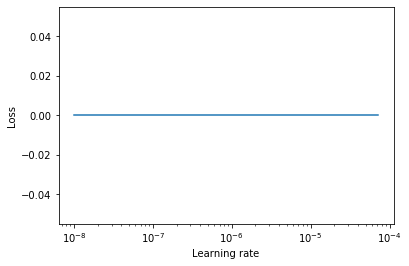

In [48]:
plt.plot(logs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()